# Uniaxial Gradient Damage

This notebook computes the behavior of a gradient damage material under uniaxial traction.

In [1]:
import matplotlib
params = {"axes.titlesize": 14,
          "axes.labelsize": 14,
          "font.size": 14,
          "xtick.labelsize": 14,
          "ytick.labelsize": 14,
          "legend.fontsize": 14}
matplotlib.rcParams.update(params)

from sympy import *
import numpy as np
import matplotlib.pyplot as plt
init_printing()

class UniaxialTractionGradientDamage():
    """
    Uniaxial traction/compression problem of a gradient damage material
    
    Conventions:
    
    - Axis 3 is the axial direction, self.eps33 the axial strain
    - Axes 1 and 2 are transversal directions, self.eps11 the transversal strain
    
    - Traction case, self.eps33 > 0
    - Compression case, self.eps33 < 0
    
    """
    
    def __init__(self, law, case):
        
        self.law = law  # PAMM or AT
        self.case = case  # "Traction" or "Compression"
        
        # Symbols
        self.E, self.nu, self.w1 = symbols("E, nu, w_1", positive=True, real=True)
        self.eps11, self.eps33 = symbols("epsilon_11, epsilon_33", real=True)
        self.alpha = symbols("alpha", positive=True, real=True)
        self.lmbda = self.nu*self.E/((1+self.nu)*(1-2*self.nu))
        self.mu = self.E/(2*(1+self.nu))
        
        # Symbolic computation
        self._solve_eps11_as_33()  # ensure that sig11 = sig22 = 0
        self._solve_eps33()  # satisfy damage criterion
        self._solve_eps11()
        self._solve_sig33()
    
    def a(self):
        """
        Local stiffness degradation due to damage
        """
        return (1-self.alpha)**2
    
    def w(self):
        """
        Local damage dissipation
        """
        if self.law == "PAMM":
            return self.alpha
        elif self.law == "AT":
            return self.alpha**2
        else:
            raise Exception("self.law can only be PAMM or AT")
    
    def eps(self):
        """
        Total strain corresponding to a uniaxial test
        """
        
        return Matrix([[self.eps11, 0, 0],
                       [0, self.eps11, 0],
                       [0, 0, self.eps33]])
    
    def linear_elastic(self, eps):
        """
        Linear elastic law
        """
        
        return simplify(self.lmbda*trace(eps)*eye(3) + 2*self.mu*eps)
    
    def epspos(self):
        """
        Part of the strain contributing to damage
        depending on self.case
        
        By default the symmetric case is considered (no distinction)
        """
        
        if self.case == "Traction":
            return self.eps()
        else:
            return self.eps()
    
    def epsneg(self):
        """
        Part of the strain resisting to damage
        """
        
        return simplify(self.eps() - self.epspos())
    
    def sigpos(self):
        """
        Part of the stress contributing to damage
        
        In general it is obtained by applying Hooke's law to epspos
        """
        
        return simplify(self.linear_elastic(self.epspos()))
    
    def signeg(self):
        """
        Part of the stress resisting damage
        """
        
        return simplify(self.linear_elastic(self.eps()) - self.sigpos())
    
    def sig(self):
        """
        Total stress tensor
        
        Due to the uniaxial condition, sig11 and sig22 should be 0
        """
        
        return simplify(self.a()*self.sigpos() + self.signeg())
    
    def psipos(self):
        """
        Part of the elastic energy contributing to damage
        """
        
        return simplify(Rational(1, 2)*trace(self.sigpos().T*self.eps()))
    
    def psineg(self):
        """
        Part of the elastic energy resisting damage
        """
        
        return simplify(Rational(1, 2)*trace(self.signeg().T*self.eps()))
    
    def W(self):
        """
        Total energy density
        """
        
        return simplify(self.a()*self.psipos() + self.psineg() + self.w1*self.w())
    
    def dW(self):
        """
        Derivative of the total energy density wrt. damage
        """
        
        return simplify(diff(self.W(), self.alpha))
    
    def set_eps0_sig0(self, alpha=None):
        """
        Set the reference strain/stress
        
        if alpha = None: sig0 corresponds to the maximal stress
                         by solving dsig33/dalpha = 0
        otherwise, sig0 = sig33(alpha)
        """
        if alpha is None:
            res = solve(diff(self._sig33, self.alpha), self.alpha)
            if len(res) != 1:
                raise Exception("Unable to solve dsig33/dalpha = 0")
            else:
                self._alpha0 = res[0]
        else:
            self._alpha0 = alpha
        self._eps0 = simplify(self._eps33.subs(self.alpha, self._alpha0))
        self._sig0 = simplify(self._sig33.subs(self.alpha, self._alpha0))
    
    def compute(self, alpha_array, nu=0):
        """
        Compute the uniaxial response while damage evolves according to alpha_array
        
        Return eps33, eps11, sig33
        """
        
        # Numerical computation
        _eps33 = lambdify((self.nu, self.alpha), self._eps33/self._eps0)
        _eps11 = lambdify((self.nu, self.alpha), self._eps11/self._eps0)
        _sig33 = lambdify((self.nu, self.alpha), self._sig33/self._sig0)

        eps33 = []
        eps11 = []
        sig33 = []
        for alpha in alpha_array:
            eps33.append(_eps33(nu, alpha))
            eps11.append(_eps11(nu, alpha))
            sig33.append(_sig33(nu, alpha))

        return (np.array(eps33), np.array(eps11), np.array(sig33))
    
    def plot(self, alpha_array, nu=0, title=""):
        """
        Plot alpha and sig33 as a function of eps33
        """
        
        eps33, eps11, sig33 = self.compute(alpha_array, nu)

        eps33 = np.hstack([np.array([0]), eps33])
        sig33 = np.hstack([np.array([0]), sig33])

        plt.plot(eps33, sig33, label=r"$\sigma_{33}\,/\,\sigma_0$")
        plt.plot(eps33[1:], alpha_array, label=r"$\alpha$")
        plt.xlabel(r"$\varepsilon_{33}\,/\,\varepsilon_0$")
        plt.legend()
        plt.title(title).set_y(1.02)
        plt.grid()
        plt.tight_layout()
    
    def _solve_eps11_as_33(self):
        """
        Use the uniaxial condition sig11 = sig22 = 0 to
        deduce eps11 as a function of eps33
        
        """
        sig11 = self.sig()[0,0]
        self._eps11_as_33 = simplify(solve(sig11, self.eps11)[0])
    
    def _solve_eps33(self):
        """
        Using the damage criterion dW = 0 to deduce eps33
        as a function of alpha
        """
        res_list = simplify(solve(self.dW().subs(self.eps11, self._eps11_as_33), self.eps33))
        
        # Should not be empty
        if res_list == []:
            raise Exception("Cannot solve eps33 as a function alpha")
        
        # Choose the good one according to the sign
        good_ones = []
        for res in res_list:
            if res.subs(self.nu, Rational(1, 5)).subs(self.alpha, Rational(1, 2)).is_positive:
                case = "Traction"
            else:
                case = "Compression"
            if case == self.case:
                good_ones.append(res)
        
        # If only one good value is found, good!
        if len(good_ones) == 1:
            self._eps33 = good_ones[0]
        else:
            raise Exception
    
    def _solve_eps11(self):
        """
        Return eps11 as a function of alpha
        """
        self._eps11 = simplify(self._eps11_as_33.subs(self.eps33, self._eps33))
    
    def _solve_sig33(self):
        """
        Return sig33 as a function of alpha
        """
        self._sig33 = simplify(self.sig()[2, 2].subs(self.eps11, self._eps11_as_33).subs(self.eps33, self._eps33))

# Symmetric case

## PAMM

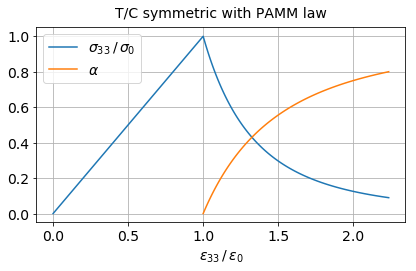

In [12]:
PAMM = UniaxialTractionGradientDamage("PAMM", "Traction")
PAMM.set_eps0_sig0(alpha=0)
PAMM.plot(alpha_array=np.linspace(0, 0.8, 100),
          title="T/C symmetric with PAMM law")

## AT

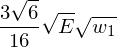

In [13]:
AT = UniaxialTractionGradientDamage("AT", "Traction")

# For AT the critical stress = 0
# Damage grows as soon as stresses are applied
# We use the maximal stress sig0 as the reference stress value
# For sig < sig0, strain hardening
# For sig > sig0, strain softening
# sig0 can be found by calculating dsig33/dalpha = 0
AT.set_eps0_sig0()
AT._sig0

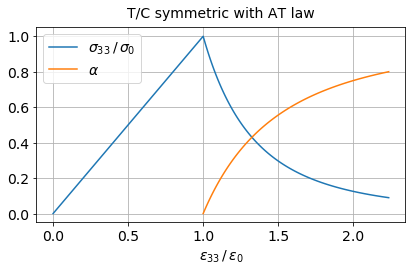

In [14]:
PAMM.plot(alpha_array=np.linspace(0, 0.8, 100),
          title="T/C symmetric with AT law")

# [Amor et al. 2009]

In [15]:
class Amor(UniaxialTractionGradientDamage):
    
     def epspos(self):
        """
        According to [Amor et al. 2009],
        under traction: epspos = eps
        under compression: epspos = dev(eps)
        """
        
        if self.case == "Traction":
            return self.eps()
        else:
            return self.eps() - trace(self.eps())/3*eye(3)

## PAMM

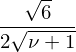

In [25]:
# Ratio between critical stresses under compression and traction

problemT = Amor("PAMM", "Traction")
problemT.set_eps0_sig0(alpha=0)

problemC = Amor("PAMM", "Compression")
problemC.set_eps0_sig0(alpha=0)

simplify(-problemC._sig0/problemT._sig0)

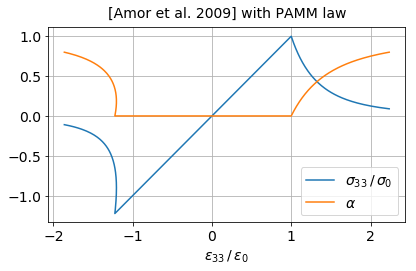

In [26]:
problemC._eps0 = problemT._eps0
problemC._sig0 = problemT._sig0

alpha = np.linspace(0, 0.8, 100)
eps33T, _, sig33T = problemT.compute(alpha, nu=0)
eps33C, _, sig33C = problemC.compute(alpha, nu=0)

eps33 = np.hstack([eps33C[::-1], np.array([0]), eps33T])
sig33 = np.hstack([sig33C[::-1], np.array([0]), sig33T])
alpha = np.hstack([alpha[::-1], np.array([0]), alpha])

plt.plot(eps33, sig33, label=r"$\sigma_{33}\,/\,\sigma_0$")
plt.plot(eps33, alpha, label=r"$\alpha$")
plt.xlabel(r"$\varepsilon_{33}\,/\,\varepsilon_0$")
plt.legend()
plt.title(r"[Amor et al. 2009] with PAMM law").set_y(1.02)
plt.grid()
plt.tight_layout()

## AT

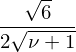

In [18]:
# Ratio between maximal stresses under compression and traction

problemT = Amor("AT", "Traction")
problemT.set_eps0_sig0()

problemC = Amor("AT", "Compression")
problemC.set_eps0_sig0()

simplify(-problemC._sig0/problemT._sig0)

# BTW, the ratio is the same as PAMM

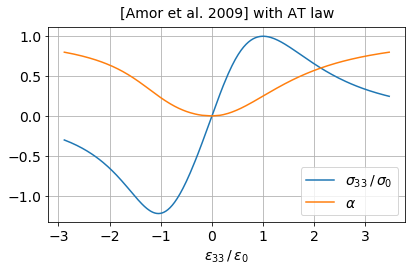

In [19]:
problemC._eps0 = problemT._eps0
problemC._sig0 = problemT._sig0

alpha = np.linspace(0, 0.8, 100)
eps33T, _, sig33T = problemT.compute(alpha, nu=0)
eps33C, _, sig33C = problemC.compute(alpha, nu=0)

eps33 = np.hstack([eps33C[::-1], np.array([0]), eps33T])
sig33 = np.hstack([sig33C[::-1], np.array([0]), sig33T])
alpha = np.hstack([alpha[::-1], np.array([0]), alpha])

plt.plot(eps33, sig33, label=r"$\sigma_{33}\,/\,\sigma_0$")
plt.plot(eps33, alpha, label=r"$\alpha$")
plt.xlabel(r"$\varepsilon_{33}\,/\,\varepsilon_0$")
plt.legend()
plt.title(r"[Amor et al. 2009] with AT law").set_y(1.02)
plt.grid()
plt.tight_layout()

# [Freddi et al. 2010]

In [6]:
class Freddi(UniaxialTractionGradientDamage):
    
     def epspos(self):
        
        if self.case == "Traction":
            return Matrix([[0, 0, 0],
                           [0, 0, 0],
                           [0, 0, 2*self.nu*self.eps11/(1-self.nu)+self.eps33]])
        else:
            return Matrix([[self.eps11+self.nu*self.eps33, 0, 0],
                           [0, self.eps11+self.nu*self.eps33, 0],
                           [0, 0, 0]])

## PAMM

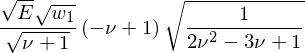

In [44]:
# Critical stress

freddi = Freddi("PAMM", "Traction")
freddi.set_eps0_sig0(alpha=0)
freddi._sig0

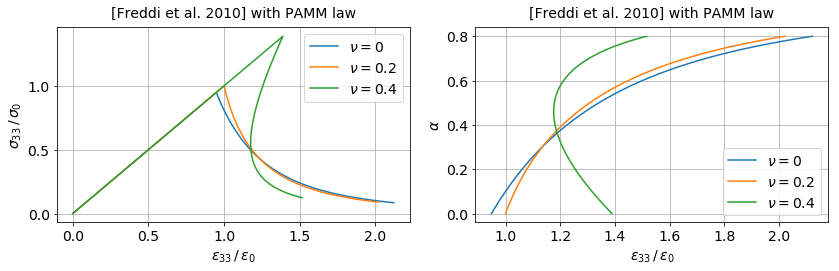

In [42]:
freddi._eps0 = freddi._eps0.subs(freddi.nu, 0.2)  # nu = 0.2 as reference
freddi._sig0 = freddi._sig0.subs(freddi.nu, 0.2)
alpha_array=np.linspace(0, 0.8, 100)

_, ax = plt.subplots(1, 2, figsize=(12, 4))

for nu in [0, 0.2, 0.4]:
    eps33, eps11, sig33 = freddi.compute(alpha_array, nu=nu)
    eps33 = np.hstack([np.array([0]), eps33])
    sig33 = np.hstack([np.array([0]), sig33])
    
    ax[0].plot(eps33, sig33, label=r"$\nu=%g$" % nu)
    ax[1].plot(eps33[1:], alpha_array, label=r"$\nu=%g$" % nu)

for i in range(2):
    ax[i].set_xlabel(r"$\varepsilon_{33}\,/\,\varepsilon_0$")
    if i == 0:
        ax[i].set_ylabel(r"$\sigma_{33}\,/\,\sigma_0$")
    else:
        ax[i].set_ylabel(r"$\alpha$")
    ax[i].legend()
    ax[i].set_title("[Freddi et al. 2010] with PAMM law").set_y(1.02)
    ax[i].grid()
plt.tight_layout()

## AT

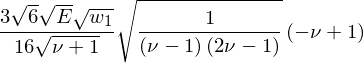

In [7]:
# Maximal stress

freddi = Freddi("AT", "Traction")
freddi.set_eps0_sig0()
freddi._sig0

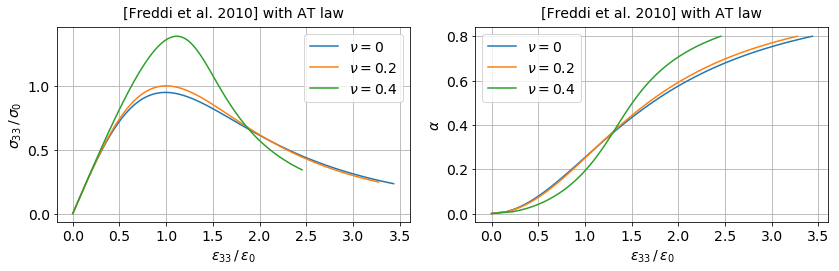

In [47]:
freddi._eps0 = freddi._eps0.subs(freddi.nu, 0.2)  # nu = 0.2 as reference
freddi._sig0 = freddi._sig0.subs(freddi.nu, 0.2)
alpha_array=np.linspace(0, 0.8, 100)

_, ax = plt.subplots(1, 2, figsize=(12, 4))

for nu in [0, 0.2, 0.4]:
    eps33, eps11, sig33 = freddi.compute(alpha_array, nu=nu)
    ax[0].plot(eps33, sig33, label=r"$\nu=%g$" % nu)
    ax[1].plot(eps33, alpha_array, label=r"$\nu=%g$" % nu)

for i in range(2):
    ax[i].set_xlabel(r"$\varepsilon_{33}\,/\,\varepsilon_0$")
    if i == 0:
        ax[i].set_ylabel(r"$\sigma_{33}\,/\,\sigma_0$")
    else:
        ax[i].set_ylabel(r"$\alpha$")
    ax[i].legend()
    ax[i].set_title("[Freddi et al. 2010] with AT law").set_y(1.02)
    ax[i].grid()
plt.tight_layout()

# [Miehe et al. 2010]

In [3]:
class Miehe(UniaxialTractionGradientDamage):
    
    def linear_elastic(self, eps, volpart=True):
        sig = 2*self.mu*eps
        if volpart:
            sig += self.lmbda*trace(self.eps())*eye(3)  # trace of the total strain
        return sig
    
    def sigpos(self):
        if self.case == "Traction":
            return simplify(self.linear_elastic(self.epspos(), True))
        else:
            return simplify(self.linear_elastic(self.epspos(), False))
    
    def epspos(self):
        if self.case == "Traction":
            return Matrix([[0, 0, 0],
                           [0, 0, 0],
                           [0, 0, self.eps33]])
        else:
            return Matrix([[self.eps11, 0, 0],
                           [0, self.eps11, 0],
                           [0, 0, 0]])

## PAMM

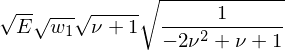

In [56]:
# Critical stress under traction

mieheT = Miehe("PAMM", "Traction")
mieheT.set_eps0_sig0(alpha=0)
mieheT._sig0

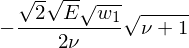

In [57]:
# Critical stress under compression

mieheC = Miehe("PAMM", "Compression")
mieheC.set_eps0_sig0(alpha=0)
mieheC._sig0

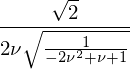

In [59]:
# Ratio between these two critical stresses
simplify(-mieheC._sig0/mieheT._sig0)

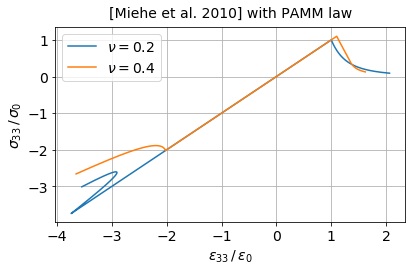

In [64]:
mieheT._eps0 = mieheT._eps0.subs(mieheT.nu, 0.2)  # nu = 0.2 as reference
mieheT._sig0 = mieheT._sig0.subs(mieheT.nu, 0.2)
mieheC._eps0 = mieheT._eps0
mieheC._sig0 = mieheT._sig0

alpha_array=np.linspace(0, 0.8, 100)

for nu in [0.2, 0.4]:
    eps33T, eps11T, sig33T = mieheT.compute(alpha_array, nu=nu)
    eps33C, eps11C, sig33C = mieheC.compute(alpha_array, nu=nu)
    
    eps33 = np.hstack([eps33C[::-1], np.array([0]), eps33T])
    sig33 = np.hstack([sig33C[::-1], np.array([0]), sig33T])
    
    plt.plot(eps33, sig33, label=r"$\nu=%g$" % nu)

plt.xlabel(r"$\varepsilon_{33}\,/\,\varepsilon_0$")
plt.ylabel(r"$\sigma_{33}\,/\,\sigma_0$")
plt.legend()
plt.title("[Miehe et al. 2010] with PAMM law").set_y(1.02)
plt.grid()
plt.tight_layout()